##Bouhourd Clément - Berrécochéa Peio - Culerier Baptiste##
#$\color{red}{\underline{\text{Homework C : Projet Lorenz}}}$


## $\color{blue}{\text{Introduction}}$
L'objectif de ce projet est de coder, analyser et observer les différences entre différentes méthodes de résolution du modèle de Lorenz. La liste exhaustive des modèles utilisés est la suivante :
<ol>
<li>BLUE (Best Linear Unbiased Estimation) avec $\underline{\underline{B}}$ constante.</li>
<li>BLUE (Best Linear Unbiased Estimation) avec $\underline{\underline{B}}$ variable.</li>
<li>Filtre de Kalman sans erreur.</li>
</ol>
Chaque résultat obtenu sera alors comparé et décrit. En approfondissement nous nous pencherons sur le modèle 4D-Var.






## $\color{blue}{\text{Analyse du modèle de Lorenz}}$
### $\color{green}{\text{Définition}}$
Fondamentalement, le modèle de Lorenz est représenté par les équations suivantes :

$$\frac{dX}{dt}=-\sigma X+\sigma Y$$


$$\frac{dY}{dt}=\rho X - Y -XZ$$


$$\frac{dZ}{dt}=XY - \beta Z$$

avec X,Y,Z fonctions du temps. Pour le système dynamique on pose $\sigma =10,\rho=28$ et $ \beta=8/3$. A $t=-10$s on pose $(X,Y,Z)=(10,15,20)$ et on intègre ensuite pour obtenir l'étrange attracteur à travers la trajectoire transitoire, pour t de -10 à 0. 
$\sigma$, $\rho$ et $\beta$ sont les paramètres du système de Lorenz, tel que ($\sigma$,$\rho$,$\beta)\in\mathbb{R}^+$.

$\sigma_r$ est l'écart type et $\tau$ l'incrément de temps permettant une discrétisation plus fine du problème et une meilleure visualisation des résultats ( tout en veillant à conserver un temps CPU convenable).





Le code ci-dessous vous permettra d'obtenir la trajectoire transitoire en 3 dimensions, la trajectoire Z en fonction de la trajectoire X et enfin la trajectoire X et Z en fonction du temps.

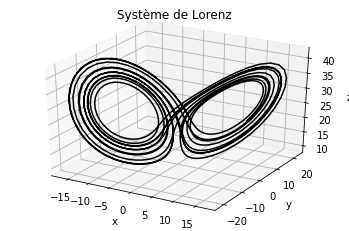

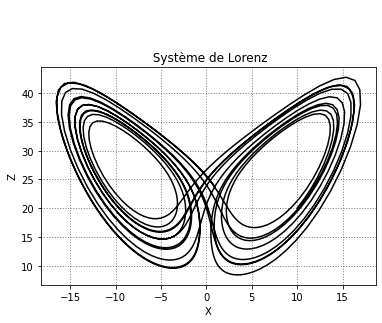

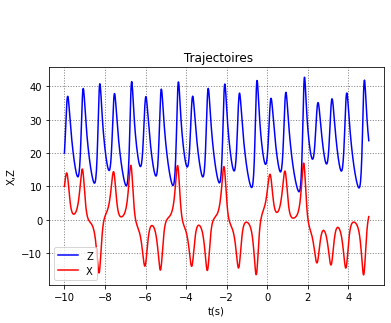

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters :
sigma = 10
rho = 28
beta = 8/3

def derivee(y,t):
    
    dx = -sigma*y[0] + sigma * y[1]
    dy = rho*y[0] - y[1] - y[0] * y[2]
    dz = y[0]*y[1] - beta* y[2]
    return [dx,dy,dz]

y0 = [10,15,20]
ts = np.linspace(-10,5,1000)
t0 = np.where(ts==0)[0][0]

y = odeint(derivee,y0,ts)


ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = y[:,2]
xline = y[:,0]
yline = y[:,1]
ax.plot3D(xline, yline, zline, 'k')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Système de Lorenz')

fig,ax = plt.subplots()
ax.plot(xline,zline,color='k')
ax.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_title('\n \n \n Système de Lorenz')

fig,ax = plt.subplots()
ax.plot(ts,zline,color = 'b', label = 'Z')
ax.plot(ts,xline, color = 'r',label='X')
ax.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
ax.set_xlabel('t(s)')
ax.set_ylabel('X,Z')
ax.set_title('\n \n \n Trajectoires')
plt.legend()


On définit alors $(X,Y,Z)$ à $t=0$ à l'aide des valeurs obtenues par intégration précédemment. L'objectif désormais est d'obtenir $\underline{\text{l'état vrai}}$ noté $(X^t(t),Y^t(t),Z^t(t))$ pour $t\in[0,t_f]$ à partir de $(X(0),Y(0),Z(0))$.


## $\color{blue}{\text{1. Code}}$


Le code suivant est à compiler pour ensuite obtenir les résultats pour chaque méthode.


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.integrate import odeint

sigma = 10
rho = 28
beta = 8/3

def derivee(y,t):
    
    dx_dt = -sigma*y[0] + sigma * y[1]
    dy_dt = rho*y[0] - y[1] - y[0] * y[2]
    dz_dt = y[0]*y[1] - beta* y[2]
    return [dx_dt,dy_dt,dz_dt]


def FdF(xdx,t,pos):
    X=pos[0]; Y=pos[1]; Z=pos[2]
    dX=xdx[0]; dY=xdx[1]; dZ=xdx[2]
    

    # Linearized trajectory
    FdX=-sigma*dX+sigma*dY
    FdY=rho*dX-dY-X*dZ-dX*Z
    FdZ=X*dZ+dX*Y-beta*dZ   
    return [FdX, FdY, FdZ]


y0 = [10,15,20]
ts = np.linspace(-10,5,1000)
t0 = np.where(ts==0)[0][0]

y = odeint(derivee,y0,ts)

t_ = ts[t0:]
t = np.linspace(0,5,51)




trueStateX = np.interp(t,t_,y[t0:,0])
trueStateY = np.interp(t,t_,y[t0:,1])
trueStateZ = np.interp(t,t_,y[t0:,2])

class LorenzModel:
    

    def __init__(self,sigmar,sigmab, B = 'constant'): 
        ### B : 'constant', 'Ak-1', 'Kalman'
        
        self.sigmab = sigmab
        self.sigmar = sigmar
        
        self.dt = 0.1
        
        self.initializeFigure()
        
        
        
        #### Initialisation #####
        self.X0 = trueStateX[0]
        self.Y0 = trueStateY[0]
        self.Z0 = trueStateZ[0]
        
        #### Initialisation of the draft #####
        self.Xa = []
        self.Xb = []

        #### Creation of the measurements y° ####
        self.measurements()

        #### First point 
        self.firstPoint()

        if B == 'constant':
            print('Starting to compute the analyze ...\nYou chose to use the case B = cte')

            for self.it in range (1,51):
                self.BLUE_Bconstant()

        if B == 'Ak-1':
            print('Starting to compute the analyze ...\nYou chose to use the case B = Ak-1')

            for self.it in range (1,51):
                self.BLUE_B__Ak()
        
        if B == 'KnoError':
            print('Starting to compute the analyze ...\nYou chose to use the case Kalman without error')

            for self.it in range (1,51):
                self.BLUE_4Dvar()
       
    
        self.ax[0].scatter(t[:], np.array(self.Xa)[:,0],label='analyse_X', facecolors='none', edgecolors='r',linewidths=2)
        self.ax[0].set_title('\n Trajectoire X(t)')

        self.ax[1].scatter(t[:], np.array(self.Xa)[:,1],label='analyse_Y', facecolors='none', edgecolors='r',linewidths=2)
        self.ax[1].set_title('\n Trajectoire Y(t)')

        self.ax[2].scatter(t[:], np.array(self.Xa)[:,2], label='analyse_Z', facecolors='none', edgecolors='r',linewidths=2)
        self.ax[2].set_title('\n Trajectoire Z(t)')
        self.ax[0].legend()
        
    def measurements(self):
        print('Realization of measurements ...')
        epsilon = np.random.normal(loc = 0, scale = self.sigmar, size =  51)
        
        self.Ymeasurements = trueStateX[0:]+ epsilon
        self.ax[0].scatter(t,self.Ymeasurements,label = 'mesure', facecolors='none', edgecolors='g',linewidths=2)
        self.ax[0].plot(t_,y[t0:,0], color='b',label = 'true state')
        self.ax[1].plot(t_,y[t0:,1], color='b',label = 'true state')

        self.ax[2].plot(t_,y[t0:,2], color='b',label = 'true state')
        
    def BLUE_Bconstant(self):
        
        ### B = cte = sigmab ** 2 * I
  
        Xb = odeint(derivee,self.Xa[-1],[self.dt * (self.it-1),self.it*self.dt])[-1]
        dk = [self.Ymeasurements[self.it] - Xb[0]]
        
        self.Xa.append(Xb + self.K@dk)
  
 
        

    def BLUE_B__Ak(self):
        
        
        self.B = self.A
        self.K = self.B@self.H.T /(self.H@self.B@(self.H.T) + self.R)
    
        
        Xb = odeint(derivee,self.Xa[-1],[self.dt * (self.it-1),self.it*self.dt])[-1]
        self.Xb.append(Xb)
        dk = [self.Ymeasurements[self.it] - Xb[0]]
       
        self.Xa.append(Xb + self.K@dk)
        
        self.A = (np.identity(3) - self.K@self.H) @ self.B

        
        
    
    def BLUE_4Dvar(self):
        
        
        t_t_dt = [self.dt * (self.it-1),self.it*self.dt]
      
        Xb = odeint(derivee,self.Xa[-1],[self.dt * (self.it-1),self.it*self.dt])[-1]
        for i in range(3):
            dxini = np.zeros(3)
            dxini[i] = 1
            sol = odeint(FdF,dxini,t_t_dt,(self.Xa[-1],))[-1]
            self.M[:,i] = sol
        self.Xb.append(Xb)
        dk = [self.Ymeasurements[self.it] - Xb[0]]

      
    
        self.B = self.M@self.A@self.M.T
        self.K = self.B@self.H.T /(self.H@self.B@(self.H.T) + self.R)
        self.Xa.append(Xb + self.K@dk)
        
        
        self.A = (np.identity(3) - self.K@self.H) @ self.B
       
     
        
    
    def initializeFigure(self):
        
        fig,ax = plt.subplots(1,3)
        fig.set_size_inches(25, 5)
        ax[0].set_xlabel('t(s)')
        ax[1].set_xlabel('t(s)')
        ax[2].set_xlabel('t(s)')

        ax[0].set_ylabel('X')
        ax[1].set_ylabel('Y') 
        ax[2].set_ylabel('Z') 

        ax[0].grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
        ax[1].grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
        ax[2].grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

        self.ax = ax
        self.fig = fig
        
    def InitializeMatrices(self):
        
        self.B = self.sigmab* self.sigmab *np.identity(3)
        self.R = self.sigmar * self.sigmar
        self.H = np.array([[1,0,0]])
        
        self.K = self.sigmab**2 / (self.sigmab**2 + self.sigmar**2) *(self.H.T)
       
        #self.K = self.B @ np.linalg.inv(self.B + self.R) @ self.H.T
        self.A = self.B
        self.M = np.zeros((3,3))
 
        
    def firstPoint(self):
        print('Initialisation : calculation of the first point ...')
        self.InitializeMatrices()
        Xb = [self.X0,self.Y0,self.Z0] + np.random.normal(loc = 0, scale = self.sigmab, size = 3)      
        self.Xb.append(Xb)
        dk = [self.Ymeasurements[0] - Xb[0]]
        Xa = (Xb + self.K @dk)
        self.Xa.append( Xa)
        
        self.A =  (np.identity(3) - self.K@self.H) @ self.B

##$\color{blue}{\text{2. Méthode BLUE avec $\underline{\underline{B}}$ constante}}$
### $\color{green}{\text{Principe}}$
Dans ce cas on pose $\underline{\underline{B}}=\sigma_b^2\underline{\underline{I}}$. L'intérêt est de pouvoir minimiser la fonctoin coût pour chaque temps $t_k$. Pour cela il suffit d'ajouter $\frac{\sigma_b^2}{\sigma_b^2+\sigma_r^2}(y_k^0-X_k^b)$ à la composante X à chaque itération de temps $t_k$. 
Toutefois, si la déviation de l'ébauche est supèrieure à celle de l'observation, traduit par $\sigma_b >>\sigma_r$, alors on remplace $X$ par $y^0$.


Realization of measurements ...
Initialisation : calculation of the first point ...
Starting to compute the analyze ...
You chose to use the case B = cte


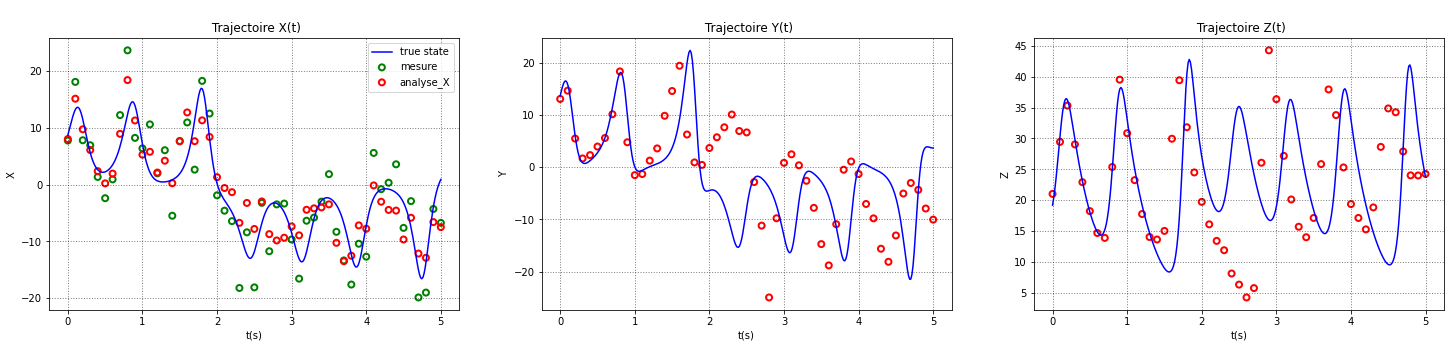

In [ ]:
# What can be changed :
Methode = 'constant'   # Different methods possible : constant, Ak-1, KnoError
sigmar = 5
sigmab = 5

# Run :
run = LorenzModel(sigmar,sigmab,Methode)

### $\color{green}{\text{Résultats}}$

Les résultats de ce premier sont plutôt corrects. En effet, l'analyse des trajetoires est particulièrement fidèle à l'état vrai pour le peu de complexité d'écriture du code mérité à l'obtention de ce résultat.

En faisant varier les coefficients $\sigma_b$ et $\sigma_r$, il est possible de se rendre compte que la meilleure façon de s'approcher de l'état vrai est de diminuer le coefficient $\sigma_r$. 

##$\color{blue}{\text{3. Méthode BLUE avec $\underline{\underline{B}}$ variable}}$
### $\color{green}{\text{Principe}}$

Cette fois-ci, la matrice $\underline{\underline{B}}$ n'est pas constante et vaut : $\underline{\underline{B}}_0 = \underline{\underline{A}}_0$ et $\underline{\underline{B}}_k = \underline{\underline{A}}_{k-1}$

Cette méthode est le première faisant intervenir la variation au cours des itérations de  la matrice de gain $\underline{\underline{K}}$ telle que : 
$\underline{\underline{K}}_k = \underline{\underline{B}}_k \underline{\underline{H}}_k^T ( \underline{\underline{H}}_k \underline{\underline{B}}_k \underline{\underline{H}}_k^T +  \underline{\underline{R}}_k)^{-1}$ 


De plus, dans cette méthode, on a : $\underline{\underline{A}}_k= (\underline{\underline{I}} -\underline{\underline{K}}\underline{G})\underline{\underline{A}}_{k-1}$ for $k = 1, ..., K$


Ce que traduit cette méthode, est que l'erreur de l'analyse de la précédente itération se propage et devient l'erreur de l'ébauche avec un certain gain.




Realization of measurements ...
Initialisation : calculation of the first point ...
Starting to compute the analyze ...
You chose to use the case B = Ak-1


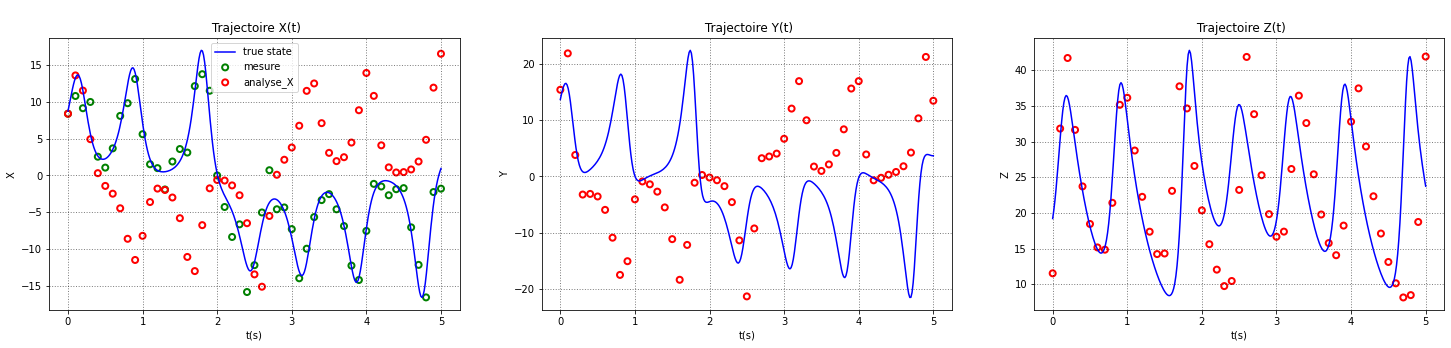

In [ ]:
# What can be changed :
Methode = 'Ak-1'   # Different methods possible : constant, Ak-1, KnoError
sigmar = 2
sigmab = 10

# Run :
run = LorenzModel(sigmar,sigmab,Methode)

### $\color{green}{\text{Résultats}}$

Il est facile de se rendre compte que les résultats donnés par cette méthode sont beaucoup trop aléatoires (lancer plusieurs simulations pour l'observer). La matrice $\underline{\underline{B}}_k$ dépendant de l'itération précédent avec $\underline{\underline{A}}_{k-1}$, les résultats de l'analyse deviennent parfois complétement faux et parfois plutôt juste. On préférera utiliser la méthode $B=cste$ pour le caractère moins aléatoire de ses résultats.



##$\color{blue}{\text{4. Méthode BLUE avec filtre de Kalman sans erreurs}}$
### $\color{green}{\text{Principe}}$


Dans cette méthode, il s'agira de faire varier la matrice d'erreur de l'ébauche $\underline{\underline{B}}_k$ telle que : $\underline{\underline{B}}_k = \underline{\underline{M}}_k \underline{\underline{A}}_{k-1} \underline{\underline{M}}_k^T$.

La matrice $\underline{\underline{M}}$ est approchée à l'aide du modèle tangeant selon le système suivant :

$$\frac{d}{dt}(dX)=-\sigma dX+\sigma dY$$


$$\frac{d}{dt}(dY) = \rho dX - dY -dXZ^b(t) - X^b(t)dZ$$


$$\frac{d}{dt}(dZ) = dXY^b(t) + X^b(t)dY - \beta dZ$$

Où $\underline{\underline{M}}_k$ est obtenu en intégrant entre 2 pas de temps $t_{k-1}$ et $t_k$ selon les conditions $(1,0,0)$, $(0,1,0)$, $(0,0,1)$ pour le vecteur $(dX,dY,dZ)$.


Realization of measurements ...
Initialisation : calculation of the first point ...
Starting to compute the analyze ...
You chose to use the case Kalman without error


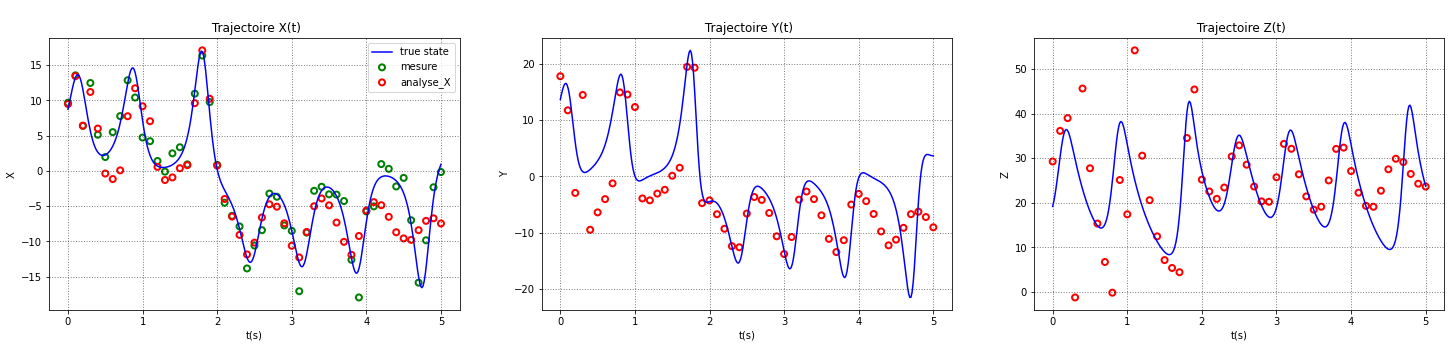

In [ ]:
# What can be changed :
Methode = 'KnoError'   # Different methods possible : constant, Ak-1, KnoError
sigmar = 2
sigmab = 10

# Run :
run = LorenzModel(sigmar,sigmab,Methode)

### $\color{green}{\text{Résultats}}$

On remarque que ce modèle a en général du mal à prédire les fortes variations des trajectoires.




##$\color{blue}{\text{Conclusion}}$


Plusieurs choses sont à noter dans ce projet :


- Les valeurs de $\sigma_b$ et $\sigma_r$ jouent un rôle important. Pour se rapprocher de l'état vrai, la meilleure chose à faire est de baisser la valeur de $\sigma_r$ qui caractérise l'erreur sur la mesure. Dans un second temps, il convient de baisser la valeur de $\sigma_b$ jusqu'à atteindre la même valeur que $\sigma_r$

- Le filtre à une grande importance pour la modélisation. En effet, ce dernier peut compléter donner de mauvais résultats selon les valeurs de $\sigma_b$ et $\sigma_r$

- Nos filtres sont peu performants car lorsque $\sigma_b$ augmente, assez rapidement le modèle devient complètement erroné.